In [21]:
import pandas as pd
import numpy as np

# from ark_tokenizer import tokenizeRawTweetText

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score

from nltk.corpus import stopwords
from nltk import word_tokenize
from tqdm import tqdm
from sklearn.cluster import KMeans

from emoji import *

import itertools
import csv
import os

import warnings
warnings.filterwarnings("ignore")

import psycopg2
from psycopg2._psycopg import IntegrityError
import csv

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

np.random.seed(8)

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth',200)
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%matplotlib inline




In [22]:
import string

def tokenize(comment, exclude_stop_words=False, exclude_punctuation=False):
    comment = comment.lower()
    words = word_tokenize(comment.lower())
    if exclude_stop_words:
        stop = set(stopwords.words('english'))
        words = list(filter(lambda word: word not in stop, words))
    if exclude_punctuation:
        exclude = set(string.punctuation)
        words = list(filter(lambda word: word not in exclude, words))
    return words

def unique_words(comment, exclude_stop_words=False):
    comment = comment.lower()
    unique = set(tokenize(comment))
    if exclude_stop_words:
        stop = set(stopwords.words('english'))
        unique = list(filter(lambda word: word not in stop, unique))
    return unique 

In [23]:
df = pd.read_csv('politics_comments_before_12_15_17_labeled.csv', names=['permalink', 'body', 'subreddit', 'label'])
# print(df.columns)
df.reset_index(drop=True)
df.index.rename('id', inplace=True)
# df.index = np.arange(1, len(df))
# df.set_index('permalink', inplace=True)
df['num_words'] = df.apply(lambda row: len(tokenize(row['body'])), axis=1)
df['num_words_minus_stop'] = df.apply(lambda row: len(tokenize(row['body'], exclude_stop_words=True)), axis=1)
df['num_unique_words'] = df.apply(lambda row: len(unique_words(row['body'])), axis=1)
df['num_unique_words_minus_stop'] = df.apply(lambda row: len(unique_words(row['body'], exclude_stop_words=True)), axis=1)
# print(df['num_words'].min())

# print(df.iloc[0])

max_num_words = df['num_words'].max()
avg_num_words = df['num_words'].mean()

max_num_minus_stop_words = df['num_words_minus_stop'].max()
avg_num_minus_stop_words = df['num_words_minus_stop'].mean()

aggressive_comments = df[df['label'] == '1']
not_aggressive_comments = df[df['label'] == '0']

labeled_df = df[(df['label'] == '1') | (df['label'] == '0')]

print(labeled_df.shape)

(2500, 8)


In [26]:
X, y = labeled_df['body'], list(labeled_df['label'])

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=100,
                             min_df=2, stop_words='english',
                             use_idf=True)

X = tfidf_vectorizer.fit_transform(labeled_df['body'].values)
X = X.todense()

km = KMeans(n_clusters=2)

km.fit(X)

clusters = km.labels_.tolist()
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [25]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1, verbose=True)
print(mds)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
print('done fitting and transforming')
xs, ys = pos[:, 0], pos[:, 1]
cluster_names = {
    0: 'Not aggressive', 
    1: 'Aggressive', 
}

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=1, random_state=1, verbose=True)
done fitting and transforming


(2500, 3)
0
continuing
1
continuing


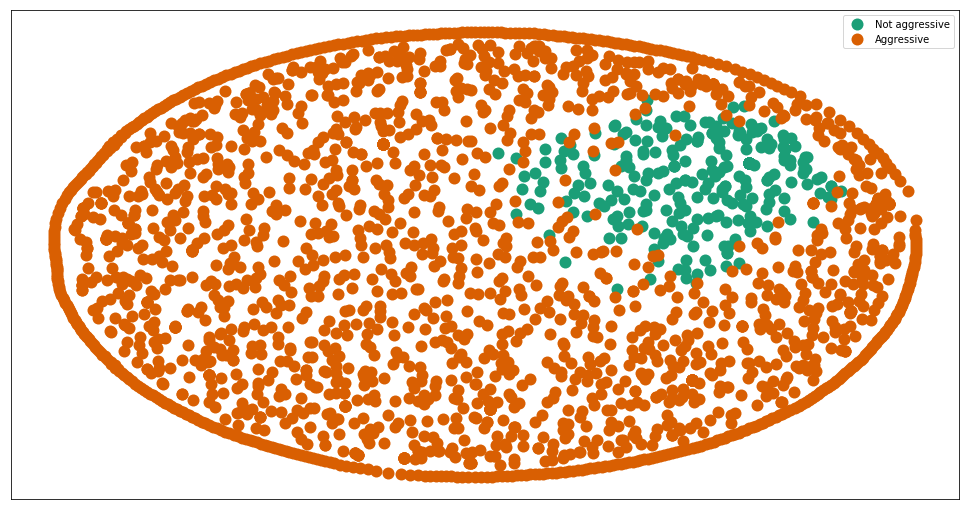

In [20]:
# labeled_df['body']
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) #, comment=labeled_df['body']))  can add to inclusde comments
print(df.shape)
#group by cluster
groups = df.groupby('label')
print(groups)

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

cluster_colors = {0: '#1b9e77', 1: '#d95f02', '0': '#7570b3', '1': '#e7298a'}

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    print(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    print('continuing')
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot
# print(plt)
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)
